In [1]:
import time

import torch
from scripts import load_dataset
from scripts.encoder_model_wrapper import BertTextClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model: BertTextClassifier = torch.load(
    "../../../results/bert_results/model.nosync/model.pt", map_location=device
)

Using device: cpu


In [3]:
def tokenize_function(examples):
    input_tokenized = model.tokenizer(
        examples["text"], padding="max_length", max_length=512, truncation=True
    )
    return {
        "input_ids": input_tokenized.input_ids,
        "attention_mask": input_tokenized.attention_mask,
    }

In [4]:
_, test_ds = load_dataset.load_dataset(
    "../../../../German_newspaper_articles/10kGNAD/train.csv",
    "../../../../German_newspaper_articles/10kGNAD/test.csv",
)

In [5]:
test_ds = test_ds.map(tokenize_function)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [6]:
test_ds = test_ds.map(load_dataset.add_label_id)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [7]:
y_true = []
y_pred = []
wrong = []
wrong_international_panorama = []


def test():
    model.eval()
    test_ds.set_format("torch", device=device)
    start_time = time.perf_counter()
    for data in test_ds:
        label_id = torch.unsqueeze(data["label_id"], 0)

        output = model(
            torch.unsqueeze(data["input_ids"], 0),
            torch.unsqueeze(data["attention_mask"], 0),
        )
        output = torch.argmax(output)

        global y_true
        global y_pred
        y_true.append(label_id.item())
        y_pred.append(output.item())

        if label_id.item() is not output.item():
            global wrong
            item = {
                "text": data["text"],
                "prediction": load_dataset.id_to_label[output.item()],
                "label": data["label"],
            }
            wrong.append(item)

        if label_id.item() == 1 and output.item() == 4:
            wrong_international_panorama.append(data["text"])
            
    end_time = time.perf_counter()
    print(f"Test took {(end_time - start_time)/60:0.4f} minutes")

In [8]:
test()

Test took 2.1655 minutes


In [20]:
wrong_international_panorama[10]

'Angriffe auf Polizei und Feuerwehr, "Araber raus"-Parolen und ein verwüstetes muslimisches Gebetshaus. Was ist da los auf Korsika?. Bis zum 4. Jänner sind in Teilen der korsischen Hauptstadt Ajaccio Kundgebungen untersagt. Zuvor gab es Übergriffe auf Sicherheitskräfte und tagelange antiarabische Demonstrationen. Aber was ist auf der französischen Mittelmeerinsel eigentlich passiert? Hier einige Antworten. Was war der Auslöser für die Proteste? Die derzeitige Eskalation begann Donnerstagnacht, am 24. Dezember. In dem Einwandererviertel Jardins de LEmpereur der korsischen Hauptstadt Ajaccio wurde Feuer gelegt, um Polizei und Feuerwehr gezielt dorthin zu locken. Die eintreffenden Einsatzkräfte sind von jugendlichen Angreifern mit Eisenstangen und Baseballschlägern attackiert worden. Das Resultat: Zwei Feuerwehrleute und ein Polizist sind verletzt. Einer der Angreifer soll antikorsische Parolen gerufen haben. Als Reaktion auf diesen Übergriff auf Sicherheitskräfte kam es zu gewalttätigen 

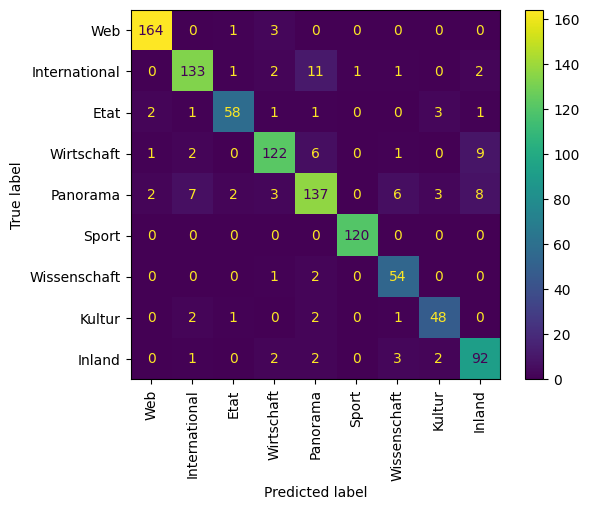

In [14]:
labels = [
    "Web",
    "International",
    "Etat",
    "Wirtschaft",
    "Panorama",
    "Sport",
    "Wissenschaft",
    "Kultur",
    "Inland",
]
disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=labels, xticks_rotation="vertical"
)

In [15]:
metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "precision_macro": precision_score(y_true, y_pred, average="macro"),
    "precision_micro": precision_score(y_true, y_pred, average="micro"),
    "recall_macro": recall_score(y_true, y_pred, average="macro"),
    "recall_micro": recall_score(y_true, y_pred, average="micro"),
    "f1_micro": f1_score(y_true, y_pred, average="micro"),
    "f1_macro": f1_score(y_true, y_pred, average="macro"),
}
metrics

{'accuracy': 0.9027237354085603,
 'balanced_accuracy': 0.9046221479611185,
 'precision_macro': 0.8946529164537704,
 'precision_micro': 0.9027237354085603,
 'recall_macro': 0.9046221479611185,
 'recall_micro': 0.9027237354085603,
 'f1_micro': 0.9027237354085603,
 'f1_macro': 0.8986403990226156}